1️⃣ Import Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN
from sklearn.decomposition import PCA
from sklearn.ensemble import IsolationForest


2️⃣ Load Dataset

In [2]:
df = pd.read_csv("./data/accdata.csv")

# Combine Date & Time (optional)
df['timestamp'] = pd.to_datetime(df['Date'] + " " + df['Time'])

# Keep only sensor signals
df = df[['a', 'b', 'c']]

print(df.head())
print("Dataset shape:", df.shape)


          a         b         c
0 -1.838747  3.543418  9.126697
1  1.110910  1.810017  9.634268
2  8.829816  0.833182  4.663905
3 -0.852336 -0.124498  9.787497
4 -0.900220 -0.095768  9.835381
Dataset shape: (27937, 3)


3️⃣ Time-Window Segmentation + Feature Extraction

We extract window-level features, which will be used for both clustering and anomaly detection.

In [4]:
WINDOW_SIZE = 100
features = []

for i in range(0, len(df) - WINDOW_SIZE, WINDOW_SIZE):
    window = df.iloc[i:i + WINDOW_SIZE]

    mag = np.sqrt(
        window['a']**2 + window['b']**2 + window['c']**2
    )

    features.append([
        window['a'].mean(), window['a'].std(), window['a'].max(),
        window['b'].mean(), window['b'].std(), window['b'].max(),
        window['c'].mean(), window['c'].std(), window['c'].max(),
        mag.mean(), mag.std(), np.sum(mag**2)  # energy
    ])

X = pd.DataFrame(features, columns=[
    'a_mean','a_std','a_max',
    'b_mean','b_std','b_max',
    'c_mean','c_std','c_max',
    'mag_mean','mag_std','mag_energy'
])

print("Feature matrix shape:", X.shape)
X.head()


Feature matrix shape: (279, 12)


,a_mean,a_std,a_max,b_mean,b_std,b_max,c_mean,c_std,c_max,mag_mean,mag_std,mag_energy
0,0.168456,1.767429,8.973468,0.718739,1.825289,7.240066,9.448669,1.062484,9.940725,9.864289,0.163986,9733.082448
1,0.631926,7.368753,9.854534,0.101275,1.046717,2.738967,5.454877,3.402426,12.832921,9.812655,0.424028,9646.620074
2,0.934696,2.901829,8.456321,1.169232,2.297407,5.698200,7.345315,5.299418,11.109096,9.875912,0.160382,9755.911170
3,2.668865,3.402079,9.107543,4.601560,3.516717,9.653421,-0.206380,6.673142,10.084377,9.802797,0.181169,9612.732924
4,0.840389,1.942089,6.406884,2.151118,3.302633,10.007763,8.651591,2.026905,11.492168,9.913520,0.714414,9878.316681


4️⃣ Feature Scaling

In [5]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


🔹 PART 1: CLUSTERING (PATTERN DISCOVERY)

5️⃣ K-Means Clustering (Primary Method)

In [6]:
NUM_CLUSTERS = 3

kmeans = KMeans(n_clusters=NUM_CLUSTERS, random_state=42)
cluster_labels = kmeans.fit_predict(X_scaled)

X['Cluster'] = cluster_labels

print("Cluster distribution:")
print(X['Cluster'].value_counts())


Cluster distribution:
Cluster
1    189
2     57
0     33
Name: count, dtype: int64


6️⃣ PCA Visualization of Clusters

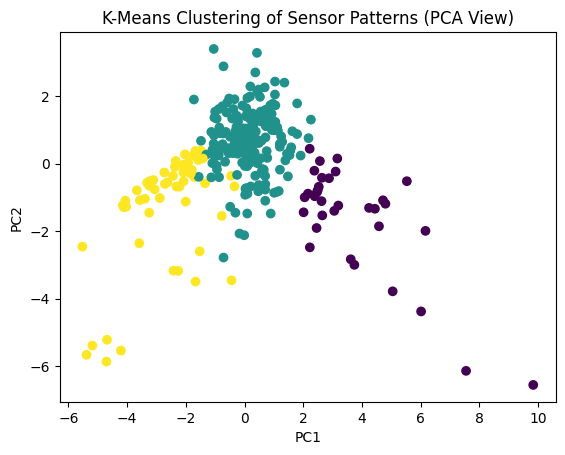

In [16]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

plt.figure()
plt.scatter(X_pca[:,0], X_pca[:,1], c=cluster_labels)
plt.title("K-Means Clustering of Sensor Patterns (PCA View)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()



7️⃣ DBSCAN (Optional – Very Good for Sensor Data)

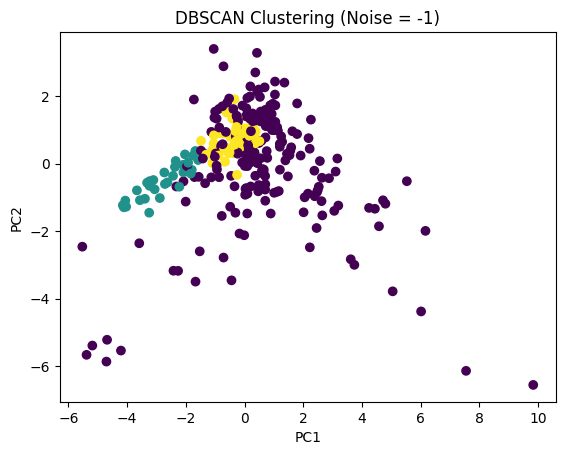

DBSCAN label distribution:
-1    198
 1     48
 0     33
Name: count, dtype: int64


In [8]:
dbscan = DBSCAN(eps=1.2, min_samples=5)
db_labels = dbscan.fit_predict(X_scaled)

plt.figure()
plt.scatter(X_pca[:,0], X_pca[:,1], c=db_labels)
plt.title("DBSCAN Clustering (Noise = -1)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()

print("DBSCAN label distribution:")
print(pd.Series(db_labels).value_counts())


🧠 How to Explain This (Clustering)

“Unsupervised clustering was applied to window-level statistical features extracted from multivariate sensor signals in order to discover latent behavioral patterns and operational states.”

🔹 PART 2: ANOMALY DETECTION (VERY STRONG USE CASE)

8️⃣ Isolation Forest (Recommended)

Isolation Forest works extremely well for sensor anomalies.

In [9]:
iso_forest = IsolationForest(
    n_estimators=200,
    contamination=0.05,   # 5% anomalies (can be tuned)
    random_state=42
)

anomaly_labels = iso_forest.fit_predict(X_scaled)

# Convert labels: 1 → Normal, -1 → Anomaly
X['Anomaly'] = anomaly_labels


9️⃣ Anomaly Distribution

In [10]:
print("Anomaly distribution:")
print(pd.Series(anomaly_labels).value_counts())


Anomaly distribution:
 1    265
-1     14
Name: count, dtype: int64


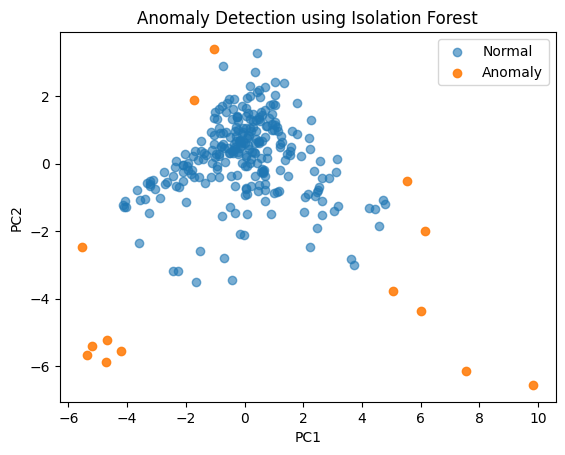

In [11]:
plt.figure()
plt.scatter(
    X_pca[anomaly_labels == 1, 0],
    X_pca[anomaly_labels == 1, 1],
    label="Normal",
    alpha=0.6
)

plt.scatter(
    X_pca[anomaly_labels == -1, 0],
    X_pca[anomaly_labels == -1, 1],
    label="Anomaly",
    alpha=0.9
)

plt.legend()
plt.title("Anomaly Detection using Isolation Forest")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()


🧠 How to Explain This (Anomaly Detection)

“An anomaly detection framework was developed using Isolation Forest to identify abnormal sensor behavior patterns. Window-level statistical features were used to detect rare and irregular events in multivariate time-series data.”

🏆 FINAL SUMMARY (What You Have Built)

| Task              | Technique                | Output                       |
| ----------------- | ------------------------ | ---------------------------- |
| Pattern Discovery | K-Means / DBSCAN         | Behavioral states            |
| Visualization     | PCA                      | Cluster & anomaly separation |
| Anomaly Detection | Isolation Forest         | Normal vs abnormal           |
| Data Type         | Multivariate time-series | Sensor-based                 |
